In [ ]:
# import de bibliothèques:
import tensorflow as tf
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, LSTM, BatchNormalization, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
import matplotlib.pyplot as plt
import time
import pickle

# Installation du drive
from google.colab import drive
drive.mount('/content/drive')
# Spécifier le chemin du dossier de destination dans Google Drive
base_path = '/content/drive/My Drive/initiation_recherche/final/'

# Fonctions personnelles de sauvegarde de resultats

def save_with_pickle(obj, filename):
    with open(filename, 'wb') as file:
        pickle.dump(obj, file)

# Fonction pour charger les données depuis un fichier pickle
def load_pkl(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Charger les variables sauvegardées lors de l'entrainement

# Charger les modèles
model_cnn_mnist = load_pkl(base_path + 'model_cnn_mnist.pkl')
model_rnn_mnist = load_pkl(base_path + 'model_rnn_mnist.pkl')
model_dnn_mnist = load_pkl(base_path + 'model_dnn_mnist.pkl')

model_cnn_cifar = load_pkl(base_path + 'model_cnn_cifar.pkl')
model_rnn_cifar = load_pkl(base_path + 'model_rnn_cifar.pkl')
model_dnn_cifar = load_pkl(base_path + 'model_dnn_cifar.pkl')

# Charger les historiques d'entraînement pour precision recall auc
history_cnn_mnist = load_pkl(base_path + 'history_cnn_mnist.pkl')
history_rnn_mnist = load_pkl(base_path + 'history_rnn_mnist.pkl')
history_dnn_mnist = load_pkl(base_path + 'history_dnn_mnist.pkl')

history_cnn_cifar = load_pkl(base_path + 'history_cnn_cifar.pkl')
history_rnn_cifar = load_pkl(base_path + 'history_rnn_cifar.pkl')
history_dnn_cifar = load_pkl(base_path + 'history_dnn_cifar.pkl')

# Charger les historiques d'entraînement pour accuracy ( il y a eu séparation en compilation entre les métriques car 'accuracy' n'a pas fonctionné avec Precision())
history_cnn_mnist_accuracy = load_pkl(base_path + 'history_cnn_mnist_accuracy.pkl')
history_rnn_mnist_accuracy = load_pkl(base_path + 'history_rnn_mnist_accuracy.pkl')
history_dnn_mnist_accuracy = load_pkl(base_path + 'history_dnn_mnist_accuracy.pkl')

history_cnn_cifar_accuracy = load_pkl(base_path + 'history_cnn_cifar_accuracy.pkl')
history_rnn_cifar_accuracy = load_pkl(base_path + 'history_rnn_cifar_accuracy.pkl')
history_dnn_cifar_accuracy = load_pkl(base_path + 'history_dnn_cifar_accuracy.pkl')

# Charger les temps d'entraînement
training_time_cnn_mnist = load_pkl(base_path + 'training_time_cnn_mnist.pkl')
training_time_rnn_mnist = load_pkl(base_path + 'training_time_rnn_mnist.pkl')
training_time_dnn_mnist = load_pkl(base_path + 'training_time_dnn_mnist.pkl')

training_time_cnn_cifar = load_pkl(base_path + 'training_time_cnn_cifar.pkl')
training_time_rnn_cifar = load_pkl(base_path + 'training_time_rnn_cifar.pkl')
training_time_dnn_cifar = load_pkl(base_path + 'training_time_dnn_cifar.pkl')


In [ ]:
# Re import des datasets:

# Télécharger les ensembles de données MNIST et CIFAR-10
(mnist_train_images, mnist_train_labels), (mnist_test_images, mnist_test_labels) = mnist.load_data()
(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = cifar10.load_data()

# Normaliser les images pour MNIST et CIFAR-10
mnist_train_images = mnist_train_images.astype('float32') / 255.0
mnist_test_images = mnist_test_images.astype('float32') / 255.0
cifar_train_images = cifar_train_images.astype('float32') / 255.0
cifar_test_images = cifar_test_images.astype('float32') / 255.0

# Redimensionner les images MNIST pour le modèle CNN (ajout d'un canal)
mnist_train_images_cnn = mnist_train_images.reshape((-1, 28, 28, 1))
mnist_test_images_cnn = mnist_test_images.reshape((-1, 28, 28, 1))

# Redimensionner les images CIFAR-10 pour le modèle CNN
cifar_train_images_cnn = cifar_train_images.reshape((-1, 32, 32, 3))
cifar_test_images_cnn = cifar_test_images.reshape((-1, 32, 32, 3))

# Redimensionner les images CIFAR-10 pour le modèle RNN
cifar_train_images_rnn = cifar_train_images.reshape((-1, 32, 32 * 3))  # Redimensionner en (32, 96)
cifar_test_images_rnn = cifar_test_images.reshape((-1, 32, 32 * 3))

# One-hot encoding des étiquettes pour MNIST et CIFAR-10
mnist_train_labels = to_categorical(mnist_train_labels, 10)
mnist_test_labels = to_categorical(mnist_test_labels, 10)
cifar_train_labels = to_categorical(cifar_train_labels, 10)
cifar_test_labels = to_categorical(cifar_test_labels, 10)

170498071/170498071 [==============================] - 2s 0us/step


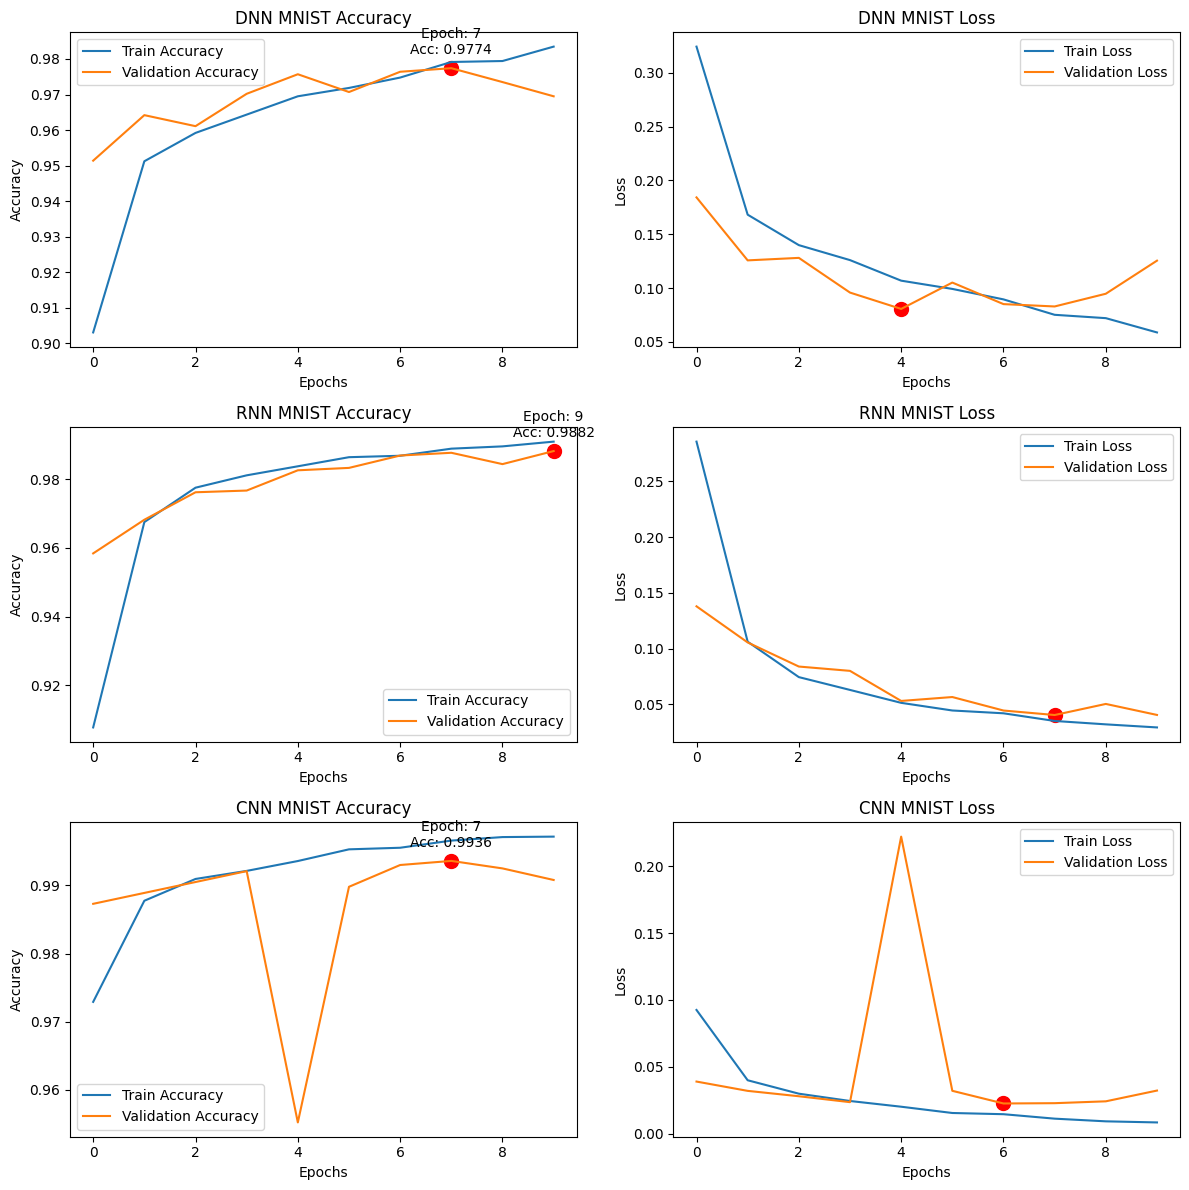

In [ ]:
# Visualiser l'accuracy et le loss pour MNIST :
def plot_model_history(model_history, model_name, subplot_row):
    # Accuracy
    plt.subplot(3, 2, subplot_row * 2 - 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    best_epoch_acc = np.argmax(model_history.history['val_accuracy'])
    best_val_acc = model_history.history['val_accuracy'][best_epoch_acc]
    plt.scatter(best_epoch_acc, best_val_acc, s=100, color='red')
    plt.annotate(f'Epoch: {best_epoch_acc}\nAcc: {best_val_acc:.4f}',
                 (best_epoch_acc, best_val_acc),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    plt.title(model_name + ' MNIST Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(3, 2, subplot_row * 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    best_epoch_loss = np.argmin(model_history.history['val_loss'])
    best_val_loss = model_history.history['val_loss'][best_epoch_loss]
    plt.scatter(best_epoch_loss, best_val_loss, s=100, color='red')
    plt.title(model_name + ' MNIST Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# Créer une figure
plt.figure(figsize=(12, 12))

# Tracer l'historique pour chaque modèle
plot_model_history(history_dnn_mnist_accuracy, 'DNN', 1)
plot_model_history(history_rnn_mnist_accuracy, 'RNN', 2)
plot_model_history(history_cnn_mnist_accuracy, 'CNN', 3)

# Afficher les graphiques
plt.tight_layout()
plt.show()

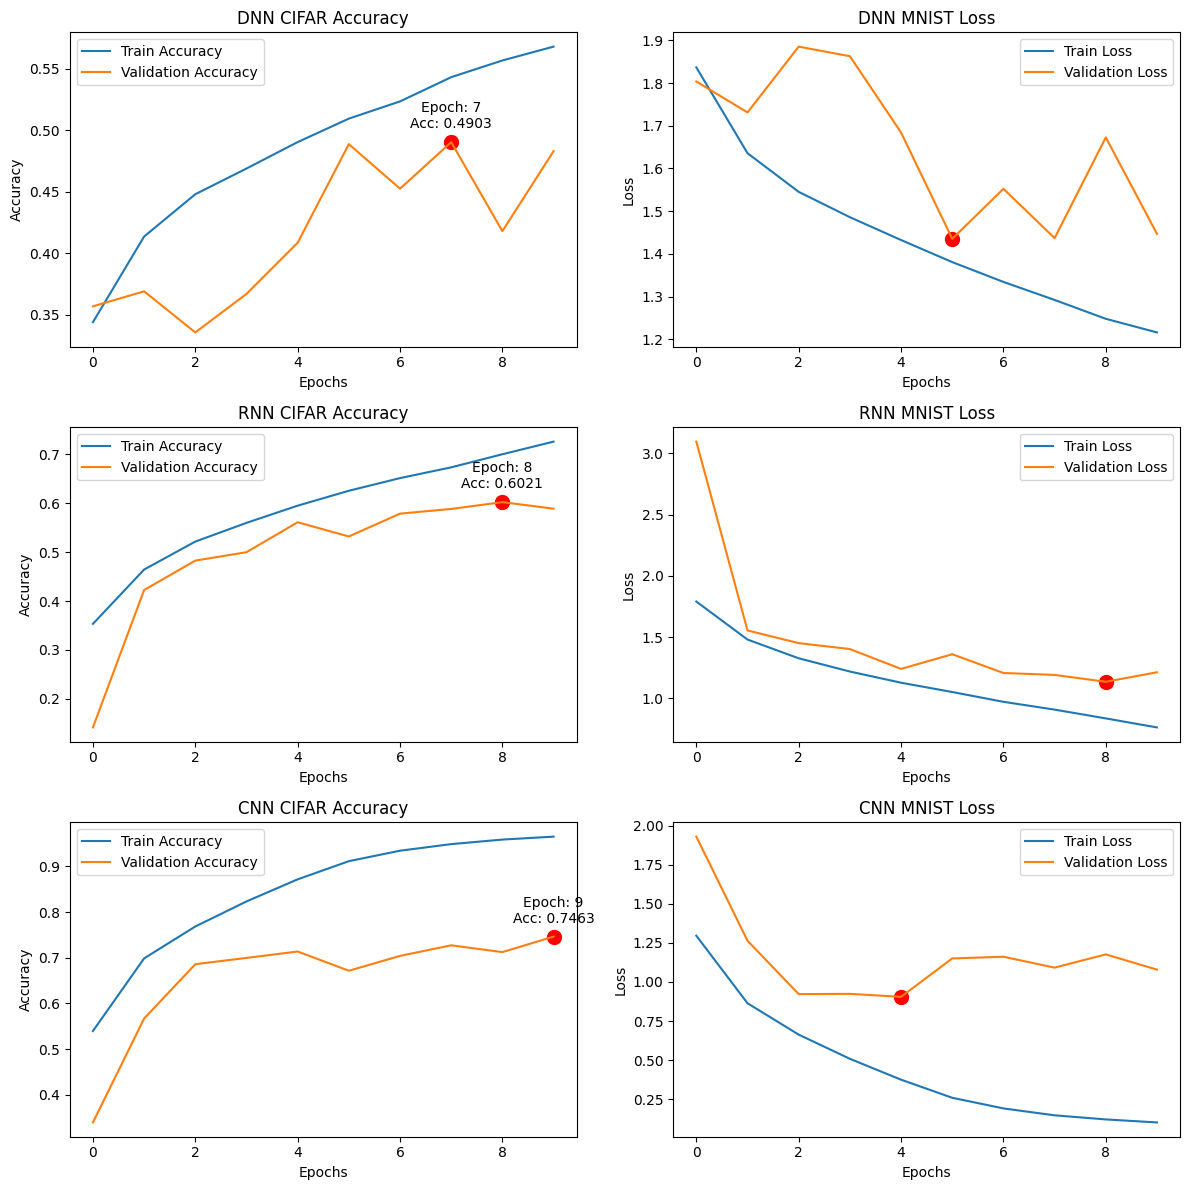

In [ ]:
# Visualiser l'accuracy et le loss pour CIFAR :
def plot_model_history(model_history, model_name, subplot_row):
    # Accuracy
    plt.subplot(3, 2, subplot_row * 2 - 1)
    plt.plot(model_history.history['accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    best_epoch_acc = np.argmax(model_history.history['val_accuracy'])
    best_val_acc = model_history.history['val_accuracy'][best_epoch_acc]
    plt.scatter(best_epoch_acc, best_val_acc, s=100, color='red')
    plt.annotate(f'Epoch: {best_epoch_acc}\nAcc: {best_val_acc:.4f}',
                 (best_epoch_acc, best_val_acc),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
    plt.title(model_name + ' CIFAR Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(3, 2, subplot_row * 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    best_epoch_loss = np.argmin(model_history.history['val_loss'])
    best_val_loss = model_history.history['val_loss'][best_epoch_loss]
    plt.scatter(best_epoch_loss, best_val_loss, s=100, color='red')
    plt.title(model_name + ' MNIST Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

# Créer une figure
plt.figure(figsize=(12, 12))

# Tracer l'historique pour chaque modèle
plot_model_history(history_dnn_cifar_accuracy, 'DNN', 1)
plot_model_history(history_rnn_cifar_accuracy, 'RNN', 2)
plot_model_history(history_cnn_cifar_accuracy, 'CNN', 3)

# Afficher les graphiques
plt.tight_layout()
plt.show()

In [ ]:
# Obtenir les rapports de classification de chaque model:

from sklearn.metrics import classification_report
import numpy as np

# Noms des classes pour MNIST et CIFAR-10
class_names_mnist = [str(i) for i in range(10)]  # MNIST a des classes de 0 à 9
class_names_cifar = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                     'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR-10 classes

# Fonction pour convertir les prédictions en étiquettes de classe
def predictions_to_labels(predictions):
    return np.argmax(predictions, axis=1)

# Fonction pour convertir les étiquettes one-hot en étiquettes de classe
def one_hot_to_labels(one_hot_labels):
    return np.argmax(one_hot_labels, axis=1)

# Obtenir les prédictions pour chaque modèle
predictions_cnn_mnist = model_cnn_mnist.predict(mnist_test_images_cnn)
predictions_rnn_mnist = model_rnn_mnist.predict(mnist_test_images)
predictions_dnn_mnist = model_dnn_mnist.predict(mnist_test_images)

predictions_cnn_cifar = model_cnn_cifar.predict(cifar_test_images_cnn)
predictions_rnn_cifar = model_rnn_cifar.predict(cifar_test_images_rnn)
predictions_dnn_cifar = model_dnn_cifar.predict(cifar_test_images)

# Convertir les prédictions en étiquettes de classe
labels_cnn_mnist = predictions_to_labels(predictions_cnn_mnist)
labels_rnn_mnist = predictions_to_labels(predictions_rnn_mnist)
labels_dnn_mnist = predictions_to_labels(predictions_dnn_mnist)

labels_cnn_cifar = predictions_to_labels(predictions_cnn_cifar)
labels_rnn_cifar = predictions_to_labels(predictions_rnn_cifar)
labels_dnn_cifar = predictions_to_labels(predictions_dnn_cifar)

# Convertir les étiquettes one-hot en étiquettes de classe
true_labels_mnist = one_hot_to_labels(mnist_test_labels)
true_labels_cifar = one_hot_to_labels(cifar_test_labels)

# Afficher le rapport de classification pour chaque modèle
print("Rapport de classification pour CNN MNIST:")
print(classification_report(true_labels_mnist, labels_cnn_mnist, target_names=class_names_mnist))

print("\nRapport de classification pour RNN MNIST:")
print(classification_report(true_labels_mnist, labels_rnn_mnist, target_names=class_names_mnist))

print("\nRapport de classification pour DNN MNIST:")
print(classification_report(true_labels_mnist, labels_dnn_mnist, target_names=class_names_mnist))

print("\nRapport de classification pour CNN CIFAR:")
print(classification_report(true_labels_cifar, labels_cnn_cifar, target_names=class_names_cifar))

print("\nRapport de classification pour RNN CIFAR:")
print(classification_report(true_labels_cifar, labels_rnn_cifar, target_names=class_names_cifar))

print("\nRapport de classification pour DNN CIFAR:")
print(classification_report(true_labels_cifar, labels_dnn_cifar, target_names=class_names_cifar))



313/313 [==============================] - 1s 3ms/step
Rapport de classification pour CNN MNIST:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


Rapport de classification pour RNN MNIST:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   

In [ ]:
# temps d'execution

print("Temps d'entraînement pour CNN MNIST :", training_time_cnn_mnist, "secondes")
print("Temps d'entraînement pour RNN MNIST :", training_time_rnn_mnist, "secondes")
print("Temps d'entraînement pour DNN MNIST :", training_time_dnn_mnist, "secondes")

print("Temps d'entraînement pour CNN CIFAR :", training_time_cnn_cifar, "secondes")
print("Temps d'entraînement pour RNN CIFAR :", training_time_rnn_cifar, "secondes")
print("Temps d'entraînement pour DNN CIFAR :", training_time_dnn_cifar, "secondes")



Temps d'entraînement pour CNN MNIST : 95.7800714969635 secondes
Temps d'entraînement pour RNN MNIST : 113.4143795967102 secondes
Temps d'entraînement pour DNN MNIST : 139.2942225933075 secondes
Temps d'entraînement pour CNN CIFAR : 88.23488903045654 secondes
Temps d'entraînement pour RNN CIFAR : 105.99268364906311 secondes
Temps d'entraînement pour DNN CIFAR : 98.28835892677307 secondes
